# Benchmark a year pixel drill

In [4]:
import dask.bag as db
import dask
from dask.diagnostics import ProgressBar

In [9]:
import xarray as xr
import fsspec
import glob
xr.set_options(display_style='text');

In [10]:
references = sorted(glob.glob('./refs/2021*_night.json'))
len(references)

197

In [2]:
def open_zarr(r):
    m = fsspec.get_mapper("reference://", 
                              remote_protocol='s3',
                    fo=r, remote_options={'anon':True,'skip_instance_cache':True,'use_listings_cache':False})
    ds = xr.open_zarr(m)
    print(ds)
    
    return ds

In [7]:
b = db.from_sequence(references,npartitions=36)
zarrs = b.map(open_zarr)
with dask.config.set(scheduler='processes'): 
    with ProgressBar():
        zarrs = zarrs.compute()

[########################################] | 100% Completed | 43.0s


In [8]:
## %%time
ds = xr.concat(zarrs,dim='time',coords='minimal',compat='override',combine_attrs='override')
ds

ValueError: 'sea_ice_fraction' is not present in all datasets.

In [73]:
with dask.config.set(scheduler='threads'):
    with ProgressBar():
        timeseries = ds.sel(lat=-32.45,lon=115.55,method='nearest').compute()

[########################################] | 100% Completed |  0.9s


(array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 array([294.64496, 294.74496, 294.84497, 294.94495, 295.04495, 295.14496,
        295.24496, 295.34497, 295.44495, 295.54495, 295.64496],
       dtype=float32),
 <BarContainer object of 10 artists>)

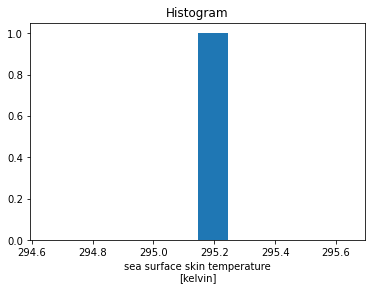

In [78]:
timeseries.sea_surface_temperature.plot()

## Median over an area in time

In [58]:
ds_crop = ds.sel(latitude=slice(-32.0,-32.5),longitude=slice(115.0,115.5))
ds_crop

<xarray.Dataset>
Dimensions:    (latitude: 51, longitude: 51, time: 202)
Coordinates:
  * latitude   (latitude) float64 -32.0 -32.01 -32.02 ... -32.48 -32.49 -32.5
  * longitude  (longitude) float64 115.0 115.0 115.0 115.0 ... 115.5 115.5 115.5
  * time       (time) datetime64[ns] 2002-07-04T05:30:00 ... 2020-02-29T05:30:00
Data variables:
    sst        (time, latitude, longitude) float32 dask.array<chunksize=(1, 3, 51), meta=np.ndarray>
Attributes:
    Conventions:    CF-1.6
    _NCProperties:  version=1|netcdflibversion=4.6.1|hdf5libversion=1.10.4
    _nc3_strict:    1
    history:        File initialised at 2020-08-06T00:45:51.567782\nInitialis...
    source_path:    imos-srs/archive/oc/aqua/1d/v201909/2002/07/A20020704.L2O...

In [59]:
with dask.config.set(scheduler='threads'):
    with ProgressBar():
        timeseries = ds_crop.stack(space=['latitude','longitude']).median(dim='space').compute()

[########################################] | 100% Completed | 43.1s


/home/ec2-user/anaconda3/envs/mxnet_latest_p37/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:995: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


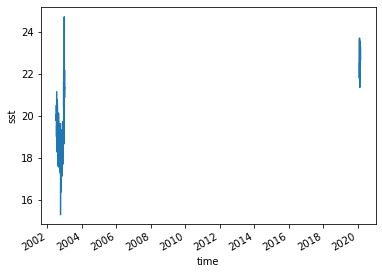

In [60]:
timeseries.sst.plot()

In [ ]:
# pretty noisy data from MODIS ....